In [1]:
import scanpy as sc
import episcanpy as epi
import anndata as ad
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as stats
import os

In [2]:
file_path='/home/ubuntu/Mouse_scATACseq_AdultCerebralCortex_10XGenomics/'
base_dir = "{}".format(file_path)

In [3]:
os.listdir(file_path) # shows all files in file_path

['gencode.vM25.basic.annotation.gtf.gz',
 'atac_v1_adult_brain_fresh_5k_singlecell.csv',
 'atac_v1_adult_brain_fresh_5k_fragments.tsv.gz',
 '5k_brain_peaks.narrowPeak',
 '10x-ATAC-Brain5k.h5ad']

In [4]:
name = "5k_brain"

fragments_file = base_dir + "/atac_v1_adult_brain_fresh_5k_fragments.tsv.gz"
peak_file = base_dir + "/{}_peaks.narrowPeak".format(name)
barcode_info = pd.read_csv(base_dir + "/atac_v1_adult_brain_fresh_5k_singlecell.csv")
print(barcode_info.is__cell_barcode.value_counts())

0    494367
1      5337
Name: is__cell_barcode, dtype: int64


In [5]:
valid_barcodes = barcode_info[barcode_info.is__cell_barcode == 1].barcode.tolist()

In [6]:
anno = ad.read(base_dir + "/10x-ATAC-Brain5k.h5ad")
anno

AnnData object with n_obs × n_vars = 2317 × 155093
    obs: 'cell_type', 'domain', 'protocol', 'dataset'
    var: 'feature_types', 'genome', 'chrom', 'chromStart', 'chromEnd', 'n_counts'

In [7]:
anno_per_bc = {bc: anno for bc, anno in zip(anno.obs.index, anno.obs.cell_type)}

In [8]:
adata = epi.ct.peak_mtx(
    fragments_file,
    peak_file,
    valid_bcs = valid_barcodes,
    normalized_peak_size=None,
    fast=False
)

adata

AnnData object with n_obs × n_vars = 5337 × 189587
    var: 'chr', 'start', 'stop'

In [9]:
adata.obs["cell_type"] = [anno_per_bc[bc] if bc in anno_per_bc else "No Annotation" for bc in adata.obs.index.tolist()]
adata.obs

,cell_type
AAACGAAAGTAATCAG-1,L5 IT
AAACGAACACGCTGTG-1,L2/3 IT
AAACGAATCCTGGGAC-1,L6 IT
AAACGAATCGGGAAAC-1,No Annotation
AAACTCGAGAAAGCAG-1,L2/3 IT
...,...
TTTGTGTGTGCTTCCT-1,No Annotation
TTTGTGTGTGGCATAG-1,No Annotation
TTTGTGTTCAGGGTTT-1,L6 CT
TTTGTGTTCTCTGCGT-1,L5 IT


In [10]:
adata.X

<5337x189587 sparse matrix of type '<class 'numpy.float32'>'
	with 26914512 stored elements in Compressed Sparse Row format>

In [11]:
means = adata.X.mean

In [12]:
adata.obs['lib_size'] = adata.X.sum(1)

In [13]:
adata.obs['mean'] = adata.X.mean(1)

In [14]:
adata.obs['var'] = adata.X.power(2).mean(1) - np.square(adata.X.mean(1))

In [15]:
print(adata.obs['lib_size'].shape)
print(adata.obs['mean'].shape)
print(adata.obs['var'].shape)

(5337,)
(5337,)
(5337,)


In [16]:
x100 = np.logspace(-4, -0.8, num=10000)
y100 = x100 + x100**2/100

In [17]:
x10 = np.logspace(-4, -0.8, num=10000)
y10 = x10 + x10**2/10

In [18]:
x1 = np.logspace(-4, -0.8, num=10000)
y1 = x1 + x1**2/1

In [19]:
x01 = np.logspace(-4, -0.8, num=10000)
y01 = x01 + x01**2/0.1

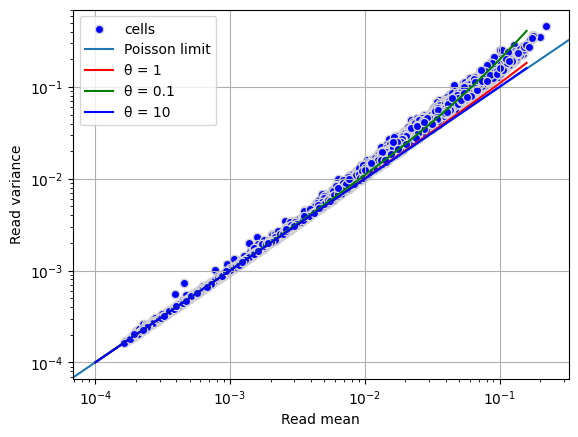

In [20]:
fig = plt.figure()
ax = fig.add_subplot()
ax.grid()
ax.scatter(x = adata.obs['mean'], y = adata.obs['var'], color='blue', edgecolors='lightgrey', label='cells')
ax.axline((0, 0), slope=1, label = 'Poisson limit')
ax.set(xscale='log', yscale='log')
ax.set_ylabel('Read variance')
ax.set_xlabel('Read mean')
plt.plot(x1,y1, 'r', label = "θ = 1")
plt.plot(x01,y01, 'g', label = "θ = 0.1")
plt.plot(x10,y10, 'b', label = "θ = 10")

ax.legend()

In [21]:
counts = adata.X
counts = counts.toarray()
counts

array([[0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       ...,
       [0., 2., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [22]:
counts.shape

(5337, 189587)

In [23]:
counts1d = counts.flatten()
counts1d.shape

(1011825819,)

In [24]:
unique, counts = np.unique(counts1d, return_counts = True)
np.asarray((unique,counts)).T

array([[0.00000000e+00, 9.84911307e+08],
       [1.00000000e+00, 2.13924990e+07],
       [2.00000000e+00, 4.22701600e+06],
       [3.00000000e+00, 9.69587000e+05],
       [4.00000000e+00, 2.39605000e+05],
       [5.00000000e+00, 6.24530000e+04],
       [6.00000000e+00, 1.65780000e+04],
       [7.00000000e+00, 4.66800000e+03],
       [8.00000000e+00, 1.44700000e+03],
       [9.00000000e+00, 4.13000000e+02],
       [1.00000000e+01, 1.39000000e+02],
       [1.10000000e+01, 6.30000000e+01],
       [1.20000000e+01, 2.40000000e+01],
       [1.30000000e+01, 1.40000000e+01],
       [1.40000000e+01, 1.00000000e+00],
       [1.50000000e+01, 2.00000000e+00],
       [1.70000000e+01, 1.00000000e+00],
       [1.90000000e+01, 1.00000000e+00],
       [2.00000000e+01, 1.00000000e+00]])

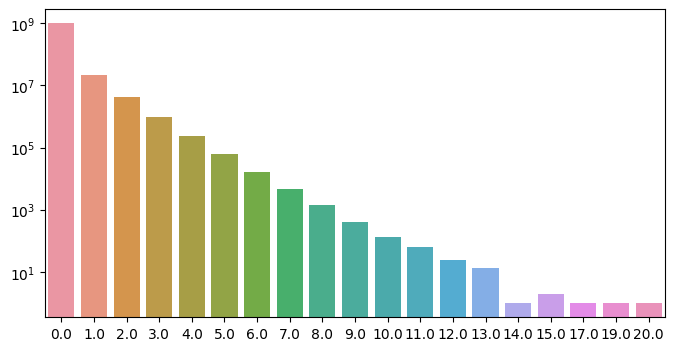

In [25]:
plt.figure(figsize=(8,4))
g = sns.barplot(x = unique, y = counts)
g.set_yscale("log")

In [26]:
adata.write("mouse_adata_base.h5ad")